1.  Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
2.  Приблизьте оба варианта моделями из класса MA.
3.  Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

## Functions

In [11]:
def tsplot(y, lags=None, figsize=(10, 6), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y,
                               lags=lags,
                               ax=pacf_ax,
                               alpha=0.05,
                               method='ywm')

        plt.tight_layout()
    return

## Load data

In [107]:
# Загрузим стационарный и нестационарный ряды
stat_df = pd.read_csv("Series\daily-total-female-births-in-cal.csv",
                      parse_dates=[0],
                      index_col=0)

non_stat_df = pd.read_csv('Series\monthly-sales-of-company-x-jan-6.csv',
                          parse_dates=[0],
                          index_col=0)


## Приближение стационарного ряда моделями скользящего среднего

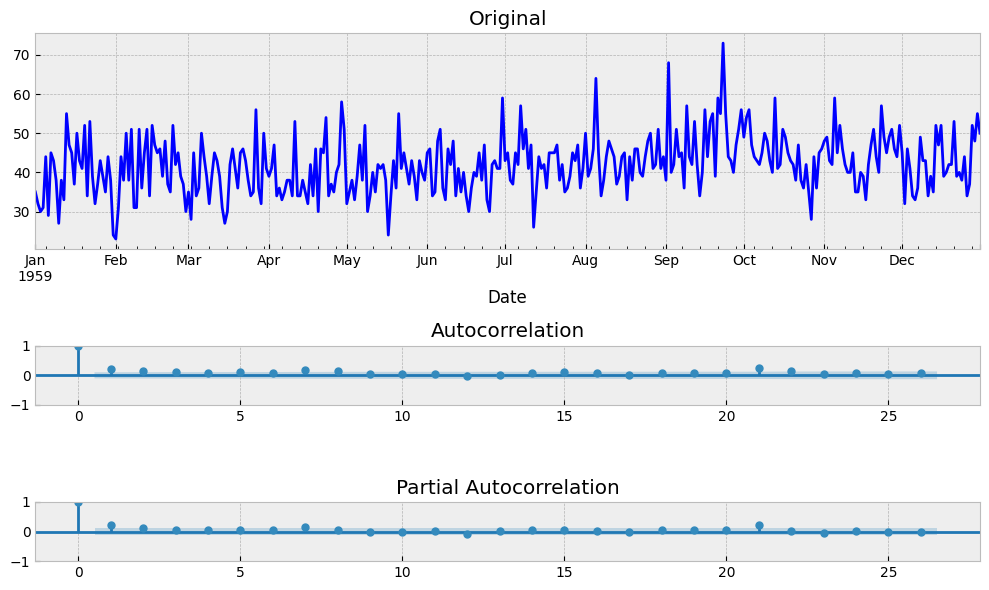

In [22]:
# Рассмотрим ряд. как мы знаем из прошлого дз, он стационарный
tsplot(stat_df.iloc[:,-1])

In [20]:
# как мы видим, данные зашумлены, для приближение воспользуемся взвешенной моделью 

def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

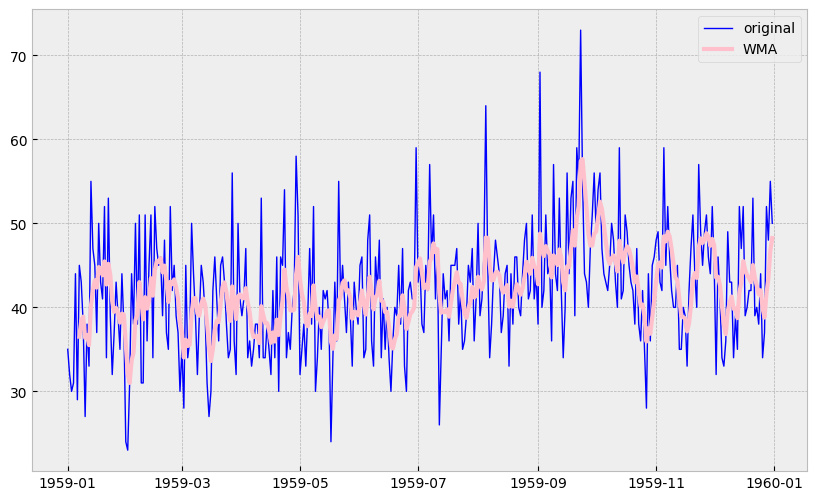

In [36]:
wma = weighted_moving_average(stat_df.iloc[:,-1], 7, [1,2,3,4,5,6,7])

with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(stat_df.iloc[:,-1], color='blue',linewidth='1',label='original')
    plt.plot(wma, color='pink', linewidth='3', label='WMA')
    plt.legend()

В данном приблежении взвешенная модель справляется отлично и хорошо убирает пики и выбросы, особенно при выбранном распределение весов 1,2,3,4,5,6,7

## Приближение нестационарного ряда моделями скользящего среднего

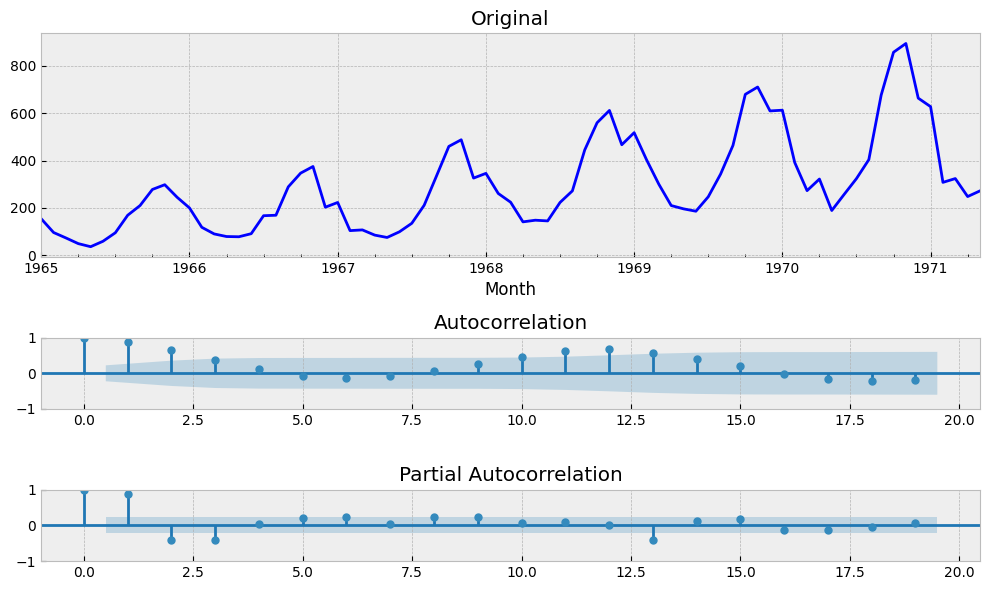

In [108]:
# Рассмотрим другой ряд. как мы знаем из прошлого дз, он нестационарный
tsplot(non_stat_df.iloc[:,-1])

В данном ряде видна четкая сезонность. Попробуем применить двойное экспоненциальное сглаживание

In [110]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

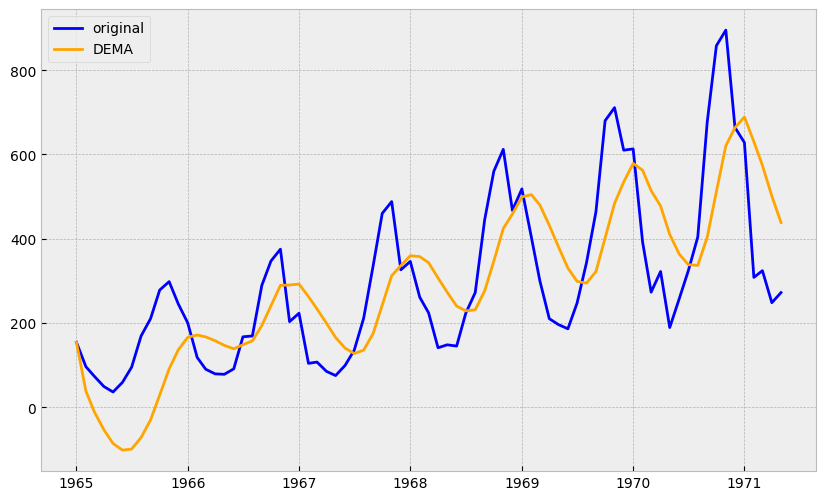

In [118]:
dema = double_ema(non_stat_df.iloc[:, -1], .1, .1)

non_stat_df_ = pd.DataFrame(double_ema(non_stat_df.iloc[:, -1], .2, .2))
non_stat_df_.index = non_stat_df.index

with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(non_stat_df['Count'],
             color='blue',
             linewidth='2',
             label='original')
    plt.plot(non_stat_df_[0], color='orange', linewidth='2', label='DEMA')
    plt.legend()

Данная модель хорошо сглаживает сезонные изменения. Данная модель быстрее и точнее реагирует на изменения, что важно в нестационарных моделях